In [1]:
import importlib
import sys

import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as functional
import yaml

sys.path.append('../')
import data
import models

CONFIG_FILE = "/home/doserbd/ain-space/local/illustris-power/config.yaml"
CHECKPOINT_FILE = "/home/doserbd/ain-space/local/illustris-power/spherinator/v85smq26/checkpoints/epoch=12-train_loss=55.40.ckpt"

with open(CONFIG_FILE, "r", encoding="utf-8") as stream:
    config = yaml.load(stream, Loader=yaml.Loader)

model_class_path = config['model']['class_path']
module_name, class_name = model_class_path.rsplit('.', 1)
module = importlib.import_module(module_name)
model_class = getattr(module, class_name)
model_init_args = config['model']['init_args']
model = model_class(**model_init_args)

checkpoint = torch.load(CHECKPOINT_FILE)
model.load_state_dict(checkpoint["state_dict"])

data_class_path = config['data']['class_path']
module_name, class_name = data_class_path.rsplit('.', 1)
module = importlib.import_module(module_name)
data_class = getattr(module, class_name)
data_init_args = config['data']['init_args']
data_module = data_class(**data_init_args)
data_module.setup("fit")
data_loader = data_module.train_dataloader()

coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0.2406], grad_fn=<SelectBackward0>)
coord tensor([ 0.6095, -0.7553, -0

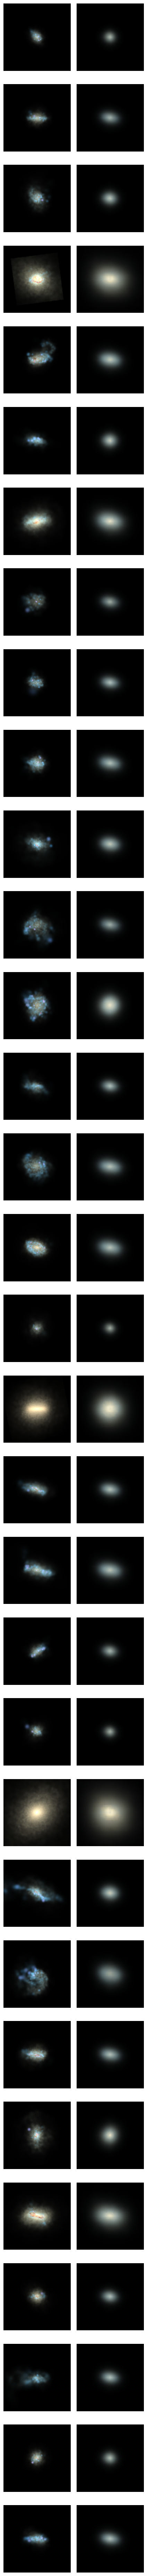

In [3]:
for batch in data_loader:
    image = batch["image"]
    input = image.to(model.device)
    batch_size = batch['id'].shape[0]
    losses = torch.zeros((batch_size, model.rotations))
    images = torch.zeros((batch_size, 3, model.input_size, model.input_size, model.rotations))
    recons = torch.zeros((batch_size, 3, model.input_size, model.input_size, model.rotations))
    coords = torch.zeros((batch_size, 3, model.rotations))
    for r in range(model.rotations):
        rotate = functional.rotate(input, 360.0 / model.rotations * r, expand=False)
        crop = functional.center_crop(rotate, [model.crop_size, model.crop_size])
        scaled = functional.resize(crop, [model.input_size, model.input_size], antialias=True)

        (z_mean, _), (q_z, p_z), _, recon = model.forward(scaled)

        loss_recon = model.reconstruction_loss(scaled, recon)
        loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).mean()

        losses[:,r] = loss_recon + model.beta * loss_KL
        images[:,:,:,:,r] = scaled
        recons[:,:,:,:,r] = recon
        coords[:,:,r] = z_mean

    min_idx = torch.min(losses, dim=1)[1]

    for i in range(batch_size):
        print("coord", coords[i,:,min_idx[i]])

    print("min: ", images.min())
    print("max: ", images.max())
    print("min: ", recons.min())
    print("max: ", recons.max())

    fig = plt.figure(figsize=(10, 3 * batch_size))
    for i in range(batch_size):
        fig.add_subplot(batch_size, 1, i+1)
        plt.imshow(images[i,:,:,:,min_idx[i]].cpu().detach().numpy().T)
        plt.axis("off")
        fig.add_subplot(batch_size, 2, i*2+2)
        plt.imshow(recons[i,:,:,:,min_idx[i]].cpu().detach().numpy().T)
        plt.axis("off")
    plt.show()

    break